In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from torch import nn
import torch


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

# Create an instance of the model
model = UNet(n_channels=3, n_classes=1)

In [3]:
model = UNet(n_channels=3, n_classes=1)
model.load_state_dict(torch.load("/content/drive/MyDrive/FILM_DATABASE/tudel_unet.1"))
model.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [6]:
!pip3 install kornia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.4/653.4 kB 5.9 MB/s eta 0:00:00


In [9]:
import os
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
import kornia
import matplotlib.pyplot as plt

color_dir = "/content/drive/MyDrive/FILM_DATABASE/image_samples/"

input_size = 512

t = transforms.Resize((input_size, input_size))(Image.open(os.path.join(color_dir, "test.png")))
t = transforms.ToTensor()(t)

g_img = kornia.color.rgb_to_hsv(t).permute((1,2,0))

In [10]:
 # Prepare the output tensor
output = torch.zeros((input_size, input_size))
size = 512

model = model.to("cuda")

    # Loop over the image patch by patch
for i in range(0, input_size, size):
    for j in range(0, input_size, size):
            # Extract the patch
        patch = g_img[i:i+size, j:j+size]

            # Make sure it's the right shape
        assert patch.shape == (size, size, 3)

            # Add an extra batch dimension, and send patch to the same device as model
        patch = patch.unsqueeze(0).to("cuda")

            # Run the model on the patch
        patch_output = model(patch.permute(0,3,1,2))

            # Remove the batch dimension and copy to CPU
        patch_output = patch_output.squeeze(0).cpu()

            # Make sure it's the right shape
        patch_output = patch_output.squeeze(0)
        assert patch_output.shape == (size, size)

            # Insert the output patch into the output image
        output[i:i+size, j:j+size] = patch_output

In [11]:
#plt.rcParams['figure.figsize'] = (10, 10)
omask = F.sigmoid(output.detach()).cpu().numpy()

In [13]:
t_gt = transforms.Resize((input_size, input_size))(Image.open(os.path.join(color_dir, "test.png")))
t_gt = transforms.ToTensor()(t_gt)

g_img = kornia.color.rgb_to_grayscale(t_gt)
threshold1=0.2
threshold2=0.32
ground_truth = torch.where(g_img > threshold1, torch.tensor(1.0), torch.tensor(0.0))
mask = torch.where(torch.tensor(omask) > threshold2, torch.tensor(1.0), torch.tensor(0.0))

In [14]:
ground_truth = ground_truth.squeeze()

In [10]:
def dice_coefficient(predicted, target):
    smooth = 1.0  # Adds a smoothing term to prevent division by zero
    product = predicted * target
    intersection = product.sum()
    coefficient = (2. * intersection + smooth) / (predicted.sum() + target.sum() + smooth)
    return coefficient

def jaccard_index(predicted, target):
    intersection = (predicted * target).sum()
    union = predicted.sum() + target.sum() - intersection
    return (intersection + 1e-10) / (union + 1e-10)

In [11]:
print(sum(mask.flatten()))
print(sum(ground_truth.flatten()))
print(dice_coefficient(mask, ground_truth))

tensor(2465.)
tensor(2309.)
tensor(0.5958)


In [12]:
import numpy as np

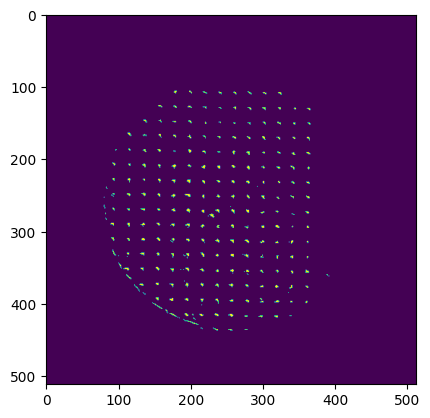

In [13]:
plt.style.use("default")
plt.imshow(mask.numpy().astype(np.uint8))

In [16]:
import cv2
import numpy as np

t2 = t.permute((1,2,0))
green = np.zeros(t2.shape, np.uint8)
green[:, :, 1] = 255
print("green: ", green.shape)
print("t: ", t2.numpy().shape)
print("mask: ", mask.numpy().shape)

green:  (512, 512, 3)
t:  (512, 512, 3)
mask:  (512, 512)


In [21]:
ori_img = cv2.imread((os.path.join(color_dir, "test.png")))
t.numpy().astype(np.uint8).dtype

dtype('uint8')

In [22]:
dst = cv2.bitwise_or(green, np.zeros(green.shape, dtype=np.uint8), mask=mask.to(torch.uint8).numpy())

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


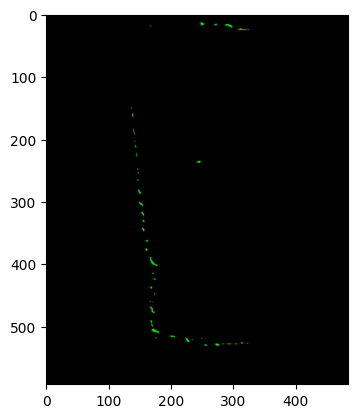

In [23]:
resize_transform = transforms.Resize((ori_img.shape[0], ori_img.shape[1]))
dst2 = torch.tensor(dst).permute((2,0,1))
dst3 = resize_transform(dst2).permute((1,2,0))
plt.imshow(dst3)

In [24]:
error_image = cv2.addWeighted(dst3.numpy(), 0.5, ori_img, 0.7, 0)

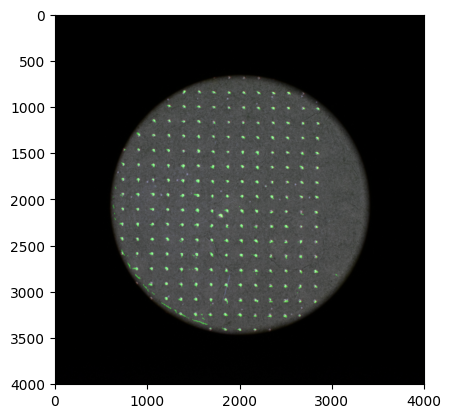

In [22]:
plt.imshow(error_image)

In [26]:
t3= (t2*120).to(torch.uint8)

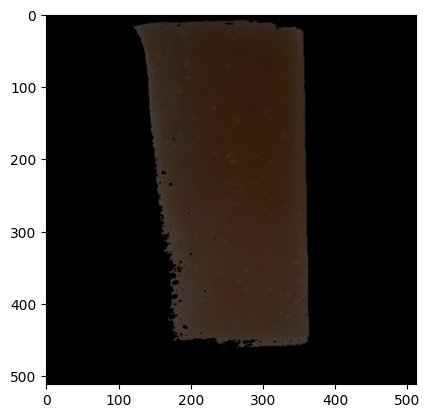

In [27]:
plt.imshow(t3)

In [31]:
np.max(t3.numpy())

70

In [34]:
# Convert the image to grayscale
gray = cv2.cvtColor(t3.numpy(), cv2.COLOR_BGR2GRAY)

# Create a binary mask where black pixels are 1 and others are 0
_, binary = cv2.threshold(gray, 1, 1, cv2.THRESH_BINARY_INV)

# Create a 7x7 kernel filled with ones
kernel = np.ones((7, t3.shape[1] // 10), np.uint8)

# Convolve the binary image with your kernel
heatmap = cv2.filter2D(binary, -1, kernel)

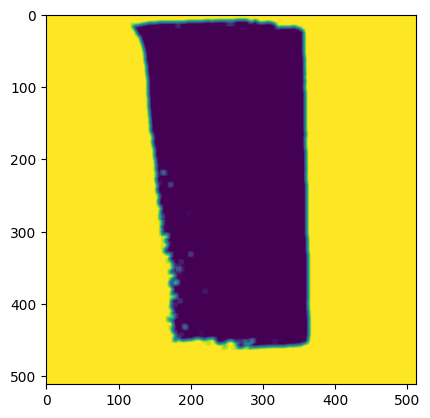

In [36]:
plt.imshow(heatmap)

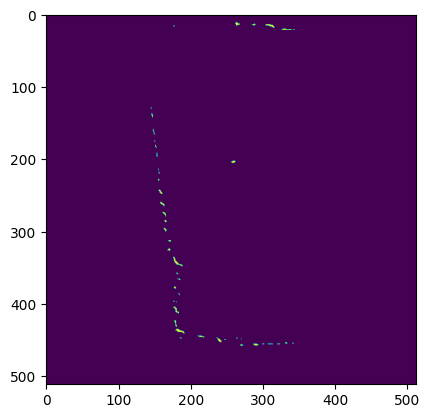

In [35]:
normalized  = abs(1 - (heatmap / np.max(heatmap)))
plt.imshow(normalized * mask.numpy())

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create two random binary masks of size [512, 512]
mask1 = mask.numpy().astype(np.uint8)
mask2 = ground_truth.squeeze(0).numpy().astype(np.uint8)

# Initialize a zeros array of same shape
overlay = np.zeros((512, 512, 3), dtype=np.uint8)

# Let's say we represent array1 with red color (first channel)
overlay[mask1 == 1] = [255, 0, 0]

# Represent array2 with green color (second channel)
overlay[mask2 == 1] = [0, 255, 0]

# Represent intersection with blue color (third channel)
# Intersection is where both array1 and array2 are 1
overlay[(mask1 == 1) & (mask2 == 1)] = [0, 0, 255]

In [ ]:
!pip3 install SciencePlots latex

In [ ]:
!apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

In [ ]:
import matplotlib.patches as mpatches
import scienceplots

plt.style.use('science')

plt.figure(figsize=(8,8))
plt.imshow(overlay)
patches = [
    mpatches.Patch(color='red', label='Prediction'),
    mpatches.Patch(color='green', label='Ground Truth'),
    mpatches.Patch(color='blue', label='Intersection')
]


# Place the legend into the plot
legend = plt.legend(handles=patches, bbox_to_anchor=(0.7, 1), loc='upper left')
for text in legend.get_texts():
    text.set_color("white")
    text.set_size("x-large")
plt.xticks([])
plt.yticks([])
plt.savefig("./overlay.png")

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/FILM_DATABASE')

In [ ]:
import mask, analysis, cv2

In [ ]:
image = cv2.imread('/content/drive/MyDrive/FILM_DATABASE/microscope_samples/square.JPG')
downsampled = cv2.resize(image, None, fx=0.1279, fy=0.1279, interpolation=cv2.INTER_LINEAR)
error_mask = analysis.errors("PEDOT", downsampled, True)
error_mask = F.sigmoid(torch.tensor(error_mask))
plt.figure(figsize=(8, 8))
plt.imshow(error_mask)

In [ ]:
plt.figure(figsize=(8, 8))
# Initialize a zeros array of same shape
td_overlay = np.zeros((512, 512, 3), dtype=np.uint8)

# Let's say we represent array1 with red color (first channel)
td_overlay[error_mask == 1] = [255, 0, 0]
plt.xticks([])
plt.yticks([])
patches = [
    mpatches.Patch(color='red', label='Heuristic\nPrediction')
]


# Place the legend into the plot
legend = plt.legend(handles=patches, bbox_to_anchor=(0.72, 1), loc='upper left')
for text in legend.get_texts():
    text.set_color("white")
    text.set_size("x-large")
plt.imshow(td_overlay)

In [ ]:
# Create a figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(24,8))

# Plot the first imshow
im1 = axs[0].imshow(t.permute((1,2,0)))
axs[0].set_title('Base Image')
axs[0].axis('off')
# Plot the second imshow
im2 = axs[1].imshow(overlay)
axs[1].set_title('U-Net Model')
axs[1].axis('off')
patches1 = [
    mpatches.Patch(color='red', label='Prediction'),
    mpatches.Patch(color='green', label='Ground Truth'),
    mpatches.Patch(color='blue', label='Intersection')
]


# Place the legend into the plot
legend1 = axs[1].legend(handles=patches1, bbox_to_anchor=(0.72, 1), loc='upper left')
for text in legend1.get_texts():
    text.set_color("white")
    text.set_size("large")

# Plot the third imshow
im3 = axs[2].imshow(td_overlay)
axs[2].set_title('Heuristic')
axs[2].axis('off')
patches2 = [
    mpatches.Patch(color='red', label='Heuristic\nPrediction')
]


# Place the legend into the plot
legend = axs[2].legend(handles=patches2, bbox_to_anchor=(0.75, 1), loc='upper left')
for text in legend.get_texts():
    text.set_color("white")
    text.set_size("large")

# Set the overall title for the figure
#fig.suptitle('Three Imshow Plots')

# Adjust the spacing between subplots
#plt.tight_layout()
plt.subplots_adjust(wspace=0)
# Show the figure
#plt.show()
plt.savefig("test.png")

from google.colab import files
files.download("test.png")
